Classifier performance
Accuracy score:  0.69
Precision score:  0.63
f1 score:  0.38
recall score:  0.28
[[297  29]
 [128  49]]

 Stock prediction performance report 
Total Trades: 78
Average return for stock predictions:  35.7 %
Average market return in the same period:  11.6% 
Compared to the index, our strategy earns  24.1 percentage points more


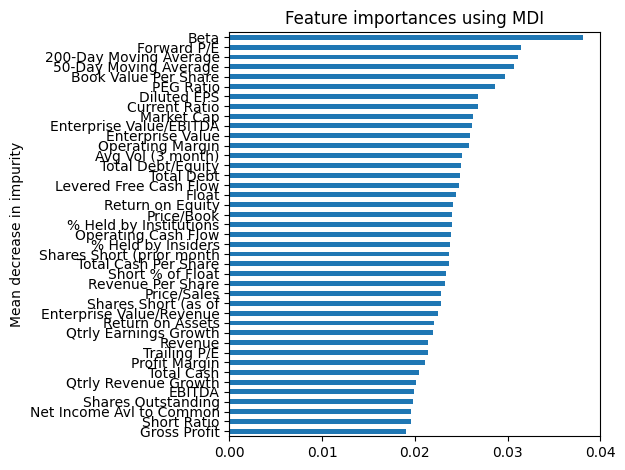

In [26]:
# Preprocessing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix
from utils import status_calc
import matplotlib.pyplot as plt


def backtest():
    """
    A simple backtest, which splits the dataset into a train set and test set,
    then fits a Random Forest classifier to the train set. We print the precision and accuracy
    of the classifier on the test set, then run a backtest comparing this strategy's performance
    to passive investment in the S&P500.
    Please note that there is a methodological flaw in this backtest which will give deceptively
    good results, so the results here should not encourage you to live trade.
    """
    # Build the dataset, and drop any rows with missing values
    data_df = pd.read_csv("keystats.csv", index_col="Date")
    data_df.dropna(axis=0, how="any", inplace=True)

    features = data_df.columns[6:]
    X = data_df[features].values

    # The labels are generated by applying the status_calc to the dataframe.
    # '1' if a stock beats the S&P500 by more than x%, else '0'. Here x is the
    # outperformance parameter, which is set to 10 by default but can be redefined.
    y = list(
        status_calc(
            data_df["stock_p_change"], data_df["SP500_p_change"], outperformance=10
        )
    )

    # z is required for us to track returns
    z = np.array(data_df[["stock_p_change", "SP500_p_change"]])

    # Generate the train set and test set by randomly splitting the dataset
    X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(
        X, y, z, test_size=0.2, shuffle = False)

    

    

    # Instantiate a RandomForestClassifier with 100 trees, then fit it to the training data
    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_train, y_train)
    

    # Generate the predictions, then print test set accuracy and precision
    y_pred = clf.predict(X_test)
    print("Classifier performance\n", "=" * 20)
    print(f"Accuracy score: {clf.score(X_test, y_test): .2f}")
    print(f"Precision score: {precision_score(y_test, y_pred): .2f}")
    print(f"f1 score: {f1_score(y_test, y_pred): .2f}")
    print(f"recall score: {recall_score(y_test, y_pred): .2f}")
    print(confusion_matrix(y_test, y_pred))
    


    
    # Because y_pred is an array of 1s and 0s, the number of positive predictions
    # is equal to the sum of the array
    num_positive_predictions = sum(y_pred)
    if num_positive_predictions < 0:
        print("No stocks predicted!")

    # Recall that z_test stores the change in stock price in column 0, and the
    # change in S&P500 price in column 1.
    # Whenever a stock is predicted to outperform (y_pred = 1), we 'buy' that stock
    # and simultaneously `buy` the index for comparison.
    stock_returns = 1 + z_test[y_pred, 0] / 100
    market_returns = 1 + z_test[y_pred, 1] / 100

    # Calculate the average growth for each stock we predicted 'buy'
    # and the corresponding index growth
    avg_predicted_stock_growth = sum(stock_returns) / num_positive_predictions
    index_growth = sum(market_returns) / num_positive_predictions
    percentage_stock_returns = 100 * (avg_predicted_stock_growth - 1)
    percentage_market_returns = 100 * (index_growth - 1)
    total_outperformance = percentage_stock_returns - percentage_market_returns

    print("\n Stock prediction performance report \n", "=" * 40)
    print(f"Total Trades:", num_positive_predictions)
    print(f"Average return for stock predictions: {percentage_stock_returns: .1f} %")
    print(f"Average market return in the same period: {percentage_market_returns: .1f}% ")
    print(f"Compared to the index, our strategy earns {total_outperformance: .1f} percentage points more")
    
    return clf, features


def feature_importance(clf_model, feature_names):



    mdi_importances = pd.Series(clf_model.feature_importances_, index=feature_names)
    tree_importance_sorted_idx = np.argsort(clf_model.feature_importances_)
    fig, ax = plt.subplots()
    mdi_importances.sort_values().plot.barh(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    
    #importances = clf_model.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in clf_model.estimators_], axis=0)
    #forest_importances = pd.Series(importances, index=feature_names)
    #fig, ax = plt.subplots()
    #forest_importances.plot.bar(yerr=std, ax=ax)
    #ax.set_title("Feature importances using MDI")
    #ax.set_ylabel("Mean decrease in impurity")
    #fig.tight_layout()
    
    


if __name__ == "__main__":
    trained_model, feature_names = backtest()
    feature_importance(trained_model, feature_names)



In [19]:
train_test_split([1,2,3,4,5,6], shuffle=False)

[[1, 2, 3, 4], [5, 6]]